In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle

import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])


import os
if not os.path.exists('./output'):
    os.makedirs('./output')


In [ ]:
def render(pgm):
    """
    Wrapper for rendering PGM via daft
    """
    for plate in pgm._plates:
        plate.render(pgm._ctx)

    for edge in pgm._edges:
        edge.render(pgm._ctx)

    for name in pgm._nodes:
        pgm._nodes[name].render(pgm._ctx)



def init_figax(pgm, fig, ax):
    """
    Wrapper for initializing PGM via daft
    """
    pgm._ctx._figure = fig
    ax.axis('off')

    # Set the bounds.
    l0 = pgm._ctx.convert(*pgm._ctx.origin)
    l1 = pgm._ctx.convert(*(pgm._ctx.origin + pgm._ctx.shape))
    ax.set_xlim(l0[0], l1[0])
    ax.set_ylim(l0[1], l1[1])
    ax.set_aspect(1)

    pgm._ctx._ax = ax

### Stochastic process over point process conditionals

In [7]:
def get_stat_model(mu, lsigma, log_beta, log_gamma, len_x, kernel_class, neurons):
    """
    """
    f_dims = neurons
    x_dims = f_dims
    
    v_t = 1.*np.ones(neurons)
    v_r = -.3*np.ones(neurons)
    tau_m = 0.01*np.ones(neurons)
    tau_s = np.ones(neurons)
    log_beta = log_beta*np.ones(neurons)
    log_gamma = log_gamma*np.ones(neurons)
    
    tau_h = 0.1*np.ones(neurons)
    a = 1.0*np.ones(neurons)
    b = 1000.0*np.ones(neurons)

    IF_model = lib.IF_models.LIF(log_beta, log_gamma, v_t, v_r, tau_s, tau_m)#, tau_h, a, b)
    
    eps_mapping = lib.mappings.Identity(f_dims)

    ### state space GP ###
    var_x = 1.0*np.ones(x_dims)  # GP variance
    len_x = len_x*np.ones((x_dims, 1))  # GP lengthscale

    kernx = kernel_class(x_dims, variance=var_x, lengthscale=len_x)
    #kernx = lib.kernels.IID(jnp.eye(x_dims))
    
    state_space = lib.GP.state_space.FullLDS(kernx, diagonal_site=True)

    ### mu and sigma ###
    params = {'value': mu*jnp.ones((f_dims,))}
    mu_mapping = lib.mappings.Constant(x_dims, f_dims, params)

    params = {'value': lsigma*jnp.ones((f_dims,))}
    lsigma_mapping = lib.mappings.Constant(x_dims, f_dims, params)
    
    ### initial conditions ###
    q_vh_ic = jnp.zeros((num_samps, neurons, IF_model.q_d))
    
    ### IF GP model ###
    model = lib.inference.IF_SSGP(
        state_space, eps_mapping, mu_mapping, lsigma_mapping, IF_model, q_vh_ic, dtype=jnp.float64)
    return model

NameError: name 'GP' is not defined

In [ ]:
neurons = 2
num_samps = 5
prng_state = jax.random.PRNGKey(123)

model = get_stat_model(
    0.1, -0.5, 3., 3., 0.01, lib.GP.kernels.Matern12, neurons)


Tsteps = 1000
t = np.linspace(0., 5., Tsteps)  # s
x_obs = jnp.empty((t.shape[0], 1, 0))
y = np.zeros((t.shape[0], neurons))
#mask = np.ones_like(y).astype(bool)
#mask[:, 0] = False
mask = None
model.set_data(t, x_obs, y, mask=mask)

In [3]:
f_dims = neurons
x_dims = f_dims

### state space GP ###
var_x = 1.0*np.ones(x_dims)  # GP variance
len_x = len_x*np.ones((x_dims, 1))  # GP lengthscale

kernx = kernel_class(x_dims, variance=var_x, lengthscale=len_x)
#kernx = lib.kernels.IID(jnp.eye(x_dims))

state_space = lib.GP.state_space.FullLDS(kernx, diagonal_site=True)



eps_samples = self.eps_mapping.sample_prior(
                eps_mapping, prng_keys[0], x_samples, jitter)

eps_samples, _ = self.eps_mapping.sample_posterior(
    eps_mapping, eps_var_params, prng_keys[0], x_samples, jitter, False)  # (time, tr, N)

NameError: name 'x_dims' is not defined

In [ ]:

Tsteps = 1000
t = np.linspace(0., 5., Tsteps)  # s
x_obs = jnp.empty((t.shape[0], 1, 0))
tr = 0
y = np.array(spiketrains[:, tr, :])
#mask = np.ones_like(y).astype(bool)
#mask[:, 0] = False
mask = None
model.set_data(t, x_obs, y, mask=mask)



model.state_space.normal_site_init(model.t.shape[0], std=1.0)
model.state_space.var_params['site_obs'] = model.state_space.var_params['site_obs'].at[500, :, 0].set(0.)

In [ ]:
def evaluate_posterior(t_eval, timedata, params, var_params, mean_only, compute_KL, jitter):

In [ ]:
x = np.exp(x)
p = x.numpy()[:, 0, :]*np.exp(-np.cumsum(x.numpy()[:, 0, :], axis=1)*dt) # natural time

In [14]:
t = np.arange(1000)
params = {"t0": 100.}

tau, dtau_dt = time_transform(params, t, inverse=False)
t_, dt_dtau = time_transform(params, tau, inverse=True)

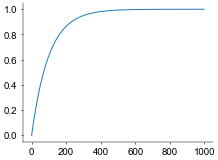

In [15]:
plt.plot(t, tau)

In [ ]:
plt.plot(tau, p.mean(0).T)
plt.plot(tau[:, None].repeat(p.shape[0], axis=1), p.T, alpha=0.3)

In [ ]:
plt.plot(t, p.mean(0).T*dtau_dt)
plt.plot(t[:, None].repeat(p.shape[0], axis=1), p.T*dtau_dt[:, None], alpha=0.3)

In [ ]:
(p*dt).sum(1)

In [ ]:
neurons = 1
hist_couple = None
shape_t = 5.0*np.ones(neurons)
likelihood = mdl.likelihoods.Gamma(sample_bin, neurons, rate_model.inv_link, shape_t)
#sigma_t = 0.5*np.ones(neurons)
#likelihood = mdl.likelihoods.logNormal(sample_bin, neurons, inv_link, sigma_t)

#mu_t = 5.0*np.ones(neurons)
#likelihood = mdl.likelihoods.invGaussian(neurons, inv_link, mu_t)

#hist_len = 99 # 100 steps of spiketrain, no instantaneous element
#hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len)
#likelihood = mdl.likelihoods.Bernoulli(neurons, inv_link)

#input_group = mdl.inference.input_group(3, [(None, None, None, 1)]*3)
#input_group.set_XZ(covariates, track_samples, batch_size=track_samples, trials=trials)

#glm = mdl.inference.VI_optimized(input_group, gauss_rate, likelihood)
#glm.to(dev)
    

bb_isi = np.linspace(0.001, 5.0, 100) # ISI evaluate

#gt_field.append(compute_rate(model.rate_model[0], [0])[0])
ISI = [torch.tensor(bb_isi[:, None], device='cpu')]#dev)]
scale = likelihood.shape.data
#scale = torch.exp(-model.likelihood.sigma.data**2/2.)
#scale = 1./model.likelihood.mu
likelihood.trials = 1
p = likelihood.nll(torch.log(scale)*torch.ones((len(bb_isi), 1), device='cpu'), [[ISI[0]*scale]], [0])#.data[:, 0].cpu().numpy()
a = np.exp(-p)

b = likelihood.ISI_dist([0]).prob_dens(bb_isi)

plt.plot(bb_isi, a)
plt.plot(bb_isi, b, 'r--')
plt.show()

In [ ]:
def searchsorted(bin_locations, inputs, eps=1e-6):
    bin_locations[..., -1] += eps
    return torch.sum(inputs[..., None] >= bin_locations, dim=-1) - 1


def RQS(
    inputs: torch.Tensor,
    unnormalized_widths: torch.Tensor,
    unnormalized_heights: torch.Tensor,
    unnormalized_derivatives: torch.Tensor,
    inverse: bool,
    left: float,
    right: float,
    bottom: float,
    top: float,
    min_bin_width: float,
    min_bin_height: float,
    min_derivative: float,
):
    """
    last dimension of params is number of bins
    first dimensions are (batch,) or (batch, dims)

    Based on implementation in https://github.com/bayesiains/nsf
    """
    if torch.min(inputs) < left or torch.max(inputs) > right:
        raise ValueError("Input outside domain")

    num_bins = unnormalized_widths.shape[-1]

    if min_bin_width * num_bins > 1.0:
        raise ValueError("Minimal bin width too large for the number of bins")
    if min_bin_height * num_bins > 1.0:
        raise ValueError("Minimal bin height too large for the number of bins")

    widths = nn.functional.softmax(unnormalized_widths, dim=-1)
    widths = min_bin_width + (1 - min_bin_width * num_bins) * widths
    cumwidths = torch.cumsum(widths, dim=-1)
    cumwidths = nn.functional.pad(cumwidths, pad=(1, 0), mode="constant", value=0.0)
    cumwidths = (right - left) * cumwidths + left
    cumwidths[..., 0] = left
    cumwidths[..., -1] = right
    widths = cumwidths[..., 1:] - cumwidths[..., :-1]

    derivatives = min_derivative + nn.functional.softplus(unnormalized_derivatives)

    heights = nn.functional.softmax(unnormalized_heights, dim=-1)
    heights = min_bin_height + (1 - min_bin_height * num_bins) * heights
    cumheights = torch.cumsum(heights, dim=-1)
    cumheights = nn.functional.pad(cumheights, pad=(1, 0), mode="constant", value=0.0)
    cumheights = (top - bottom) * cumheights + bottom
    cumheights[..., 0] = bottom
    cumheights[..., -1] = top
    heights = cumheights[..., 1:] - cumheights[..., :-1]

    if inverse:
        bin_idx = searchsorted(cumheights, inputs)[..., None]
    else:
        bin_idx = searchsorted(cumwidths, inputs)[..., None]

    input_cumwidths = cumwidths.gather(-1, bin_idx)[..., 0]
    input_bin_widths = widths.gather(-1, bin_idx)[..., 0]

    input_cumheights = cumheights.gather(-1, bin_idx)[..., 0]
    delta = heights / widths
    input_delta = delta.gather(-1, bin_idx)[..., 0]

    input_derivatives = derivatives.gather(-1, bin_idx)[..., 0]
    input_derivatives_plus_one = derivatives[..., 1:].gather(-1, bin_idx)
    input_derivatives_plus_one = input_derivatives_plus_one[..., 0]

    input_heights = heights.gather(-1, bin_idx)[..., 0]

    if inverse:
        a = (inputs - input_cumheights) * (
            input_derivatives + input_derivatives_plus_one - 2 * input_delta
        ) + input_heights * (input_delta - input_derivatives)
        b = input_heights * input_derivatives - (inputs - input_cumheights) * (
            input_derivatives + input_derivatives_plus_one - 2 * input_delta
        )
        c = -input_delta * (inputs - input_cumheights)

        discriminant = b.pow(2) - 4 * a * c
        if (discriminant >= 0).all() is False:
            raise RuntimeError('Rational quadratic spline inverse discriminant negative')

        root = (2 * c) / (-b - torch.sqrt(discriminant))
        outputs = root * input_bin_widths + input_cumwidths

        theta_one_minus_theta = root * (1 - root)
        denominator = input_delta + (
            (input_derivatives + input_derivatives_plus_one - 2 * input_delta)
            * theta_one_minus_theta
        )
        derivative_numerator = input_delta.pow(2) * (
            input_derivatives_plus_one * root.pow(2)
            + 2 * input_delta * theta_one_minus_theta
            + input_derivatives * (1 - root).pow(2)
        )
        logdetjac = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, -logdetjac

    else:
        theta = (inputs - input_cumwidths) / input_bin_widths
        theta_one_minus_theta = theta * (1 - theta)

        numerator = input_heights * (
            input_delta * theta.pow(2) + input_derivatives * theta_one_minus_theta
        )
        denominator = input_delta + (
            (input_derivatives + input_derivatives_plus_one - 2 * input_delta)
            * theta_one_minus_theta
        )
        outputs = input_cumheights + numerator / denominator

        derivative_numerator = input_delta.pow(2) * (
            input_derivatives_plus_one * theta.pow(2)
            + 2 * input_delta * theta_one_minus_theta
            + input_derivatives * (1 - theta).pow(2)
        )
        logdetjac = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, logdetjac


def unconstrained_RQS(
    inputs: torch.Tensor,
    unnormalized_widths: torch.Tensor,
    unnormalized_heights: torch.Tensor,
    unnormalized_derivatives: torch.Tensor,
    inverse: bool,
    tail_bound: float,
    min_bin_width: float,
    min_bin_height: float,
    min_derivative: float,
):
    """
    Based on implementation in https://github.com/bayesiains/nsf
    """
    outputs = torch.zeros_like(inputs)
    logdetjac = torch.zeros_like(inputs)

    unnormalized_derivatives = nn.functional.pad(unnormalized_derivatives, pad=(1, 1))
    constant = math.log(math.exp(1 - min_derivative) - 1)
    unnormalized_derivatives[..., 0] = constant
    unnormalized_derivatives[..., -1] = constant

    inside_intvl_mask = (inputs >= -tail_bound) & (inputs <= tail_bound)
    outside_interval_mask = ~inside_intvl_mask

    if outside_interval_mask.sum() > 0:
        outputs[outside_interval_mask] = inputs[outside_interval_mask]
        logdetjac[outside_interval_mask] = 0

    if inside_intvl_mask.sum() > 0:
        outputs[inside_intvl_mask], logdetjac[inside_intvl_mask] = RQS(
            inputs=inputs[inside_intvl_mask],
            unnormalized_widths=unnormalized_widths[inside_intvl_mask, :],
            unnormalized_heights=unnormalized_heights[inside_intvl_mask, :],
            unnormalized_derivatives=unnormalized_derivatives[inside_intvl_mask, :],
            inverse=inverse,
            left=-tail_bound,
            right=tail_bound,
            bottom=-tail_bound,
            top=tail_bound,
            min_bin_width=min_bin_width,
            min_bin_height=min_bin_height,
            min_derivative=min_derivative,
        )

    return outputs, logdetjac


class NRQS(nn.Module):
    """
    Neural rational quadratic spline flow, coupling layer

    [Durkan et al. 2019]
    """

    def __init__(self, mask1, f1, f2, K, B):
        """
        f1 and f2 take in full input x and map out flattened (3 * K - 1) * dims
        """
        super().__init__()
        self.dim1 = mask1.sum()
        self.dim2 = np.prod(mask1.shape) - self.dim1
        self.K = K
        self.B = B

        self.register_buffer("mask1", mask1.type(torch.bool))  # add batch dimension
        self.register_buffer("mask2", ~mask1.type(torch.bool))
        self.f1 = f1  # output (3 * K - 1) * dim2
        self.f2 = f2

    def _compute_RQS(self, x, W, H, D, inverse):
        W = 2 * self.B * torch.softmax(W, dim=2)
        H = 2 * self.B * torch.softmax(H, dim=2)
        D = nn.functional.softplus(D)
        x, ld = unconstrained_RQS(
            x, W, H, D, inverse, tail_bound=self.B, 
            min_bin_width=1e-2, min_bin_height=1e-2, min_derivative=1e-2, 
        )
        return x, ld

    def forward(self, x, reverse=False, log_px=0):
        """
        :param torch.tensor x: input of shape (batch, dims)
        """
        x1, x2 = x[:, self.mask1], x[:, self.mask2]
        x = torch.clone(x)  # copy to avoid overwriting input

        if reverse:
            x2_ = x * self.mask2
            out = self.f2(x2_).reshape(-1, self.dim1, 3 * self.K - 1)
            W, H, D = torch.split(out, self.K, dim=2)
            x1, ld = self._compute_RQS(x1, W, H, D, inverse=True)
            x[:, self.mask1] = x1  # update x1 part
            log_px = log_px + torch.sum(ld, dim=1)

            x1_ = x * self.mask1
            out = self.f1(x1_).reshape(-1, self.dim2, 3 * self.K - 1)
            W, H, D = torch.split(out, self.K, dim=2)
            x2, ld = self._compute_RQS(x2, W, H, D, inverse=True)
            x[:, self.mask2] = x2  # update x2 part
            log_px = log_px + torch.sum(ld, dim=1)

        else:
            x1_ = x * self.mask1
            out = self.f1(x1_).reshape(-1, self.dim2, 3 * self.K - 1)
            W, H, D = torch.split(out, self.K, dim=2)
            x2, ld = self._compute_RQS(x2, W, H, D, inverse=False)
            x[:, self.mask2] = x2  # update x2 part
            log_px = log_px + torch.sum(ld, dim=1)

            x2_ = x * self.mask2
            out = self.f2(x2_).reshape(-1, self.dim1, 3 * self.K - 1)
            W, H, D = torch.split(out, self.K, dim=2)
            x1, ld = self._compute_RQS(x1, W, H, D, inverse=False)
            x[:, self.mask1] = x1  # update x1 part
            log_px = log_px + torch.sum(ld, dim=1)

        return x, log_px


### Schematic

In [ ]:
fig = plt.figure(figsize=(8,5)) # plot fits
fig.text(-0.21, 1.16, 'A', transform=ax.transAxes, size=15)

time_bins = I_ext[0].shape[0]
tt = np.arange(time_bins)*dt



widths = [1]
heights = [1, 1, 1, 2]
spec = fig.add_gridspec(ncols=1, nrows=4, width_ratios=widths, height_ratios=heights, 
                        left=0., right=0.7, bottom=0., top=1.0)

ax = fig.add_subplot(spec[0, 0])